<a href="https://colab.research.google.com/github/BradenAnderson/sales-predictions/blob/main/Sales_Predictions_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Braden Anderson
### Sales Predictions Project
### Coding Dojo
### Data Science and Machine Learning Bootcamp

Goal: Understand the properties of products and outlets that play crucial roles in increasing sales.

In [204]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [205]:
import missingno
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype

from scipy import stats
from scipy.stats import norm, skew, shapiro

from sklearn.impute import SimpleImputer

%matplotlib inline

In [206]:
# Importing the sales data from a csv file to the sales_df data frame.
filename = '/content/drive/MyDrive/Programming/Colab Notebooks/Coding_Dojo/Sales_Project/sales_predictions.csv'

sales_df = pd.read_csv(filename)

In [207]:
# View the first five rows of the data.
sales_df.head()

Item_Identifier  Item_Weight  ...        Outlet_Type  Item_Outlet_Sales
0           FDA15         9.30  ...  Supermarket Type1          3735.1380
1           DRC01         5.92  ...  Supermarket Type2           443.4228
2           FDN15        17.50  ...  Supermarket Type1          2097.2700
3           FDX07        19.20  ...      Grocery Store           732.3800
4           NCD19         8.93  ...  Supermarket Type1           994.7052

[5 rows x 12 columns]

In [208]:
# Check if any of the rows are duplicates of eachother. False indicates no rows are duplicates.
sales_df.duplicated().any()

False

# Finding and visualizing missing values in the dataset

In [209]:
# .info() shows that the Item_Weight and Outlet_Size columns have some null values.
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [211]:
# Notice that "Low Fat", "LF", and "low fat" are three different inputs trying to say the same thing.
# Also notice that "Regular" and "reg" are different inputs intending to indicate the same thing.
sales_df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [212]:
# Change any "LF"'s or "low fat"'s to "Low Fat"
sales_df.loc[(sales_df['Item_Fat_Content'] == 'LF') | (sales_df['Item_Fat_Content'] == 'low fat'), 'Item_Fat_Content'] = 'Low Fat'

# Change any "regs" to "regular"
sales_df.loc[(sales_df['Item_Fat_Content'] == 'reg'), 'Item_Fat_Content'] = 'Regular'

In [213]:
# Verify that Low Fat and Regular are each now represented by a single category. 
sales_df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [214]:
# Find the total number of missing values in each column.
sales_df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [210]:
# Find the percentage of entries in each column that have missing data. 
# Item_Weight and Outlet_Size are missing a significant percentage of the data, therefore dropping missings is not a good option. 
sales_df_missing_pct = (sales_df.isna().sum() / len(sales_df)) * 100
sales_df_missing_pct

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [215]:
# Find the total number of missing values in the entire data frame.
sales_df.isnull().sum().sum()

3873

In [216]:
# View only the rows where the Item_Weight column has a NaN value.
sales_df.loc[sales_df['Item_Weight'].isna()]

Item_Identifier  Item_Weight  ...        Outlet_Type  Item_Outlet_Sales
7              FDP10          NaN  ...  Supermarket Type3          4022.7636
18             DRI11          NaN  ...  Supermarket Type3          2303.6680
21             FDW12          NaN  ...  Supermarket Type3          4064.0432
23             FDC37          NaN  ...      Grocery Store           214.3876
29             FDC14          NaN  ...      Grocery Store           125.8362
...              ...          ...  ...                ...                ...
8485           DRK37          NaN  ...  Supermarket Type3          6261.8490
8487           DRG13          NaN  ...  Supermarket Type3          4111.3150
8488           NCN14          NaN  ...  Supermarket Type3          2756.4120
8490           FDU44          NaN  ...      Grocery Store           487.3656
8504           NCN18          NaN  ...  Supermarket Type3          4138.6128

[1463 rows x 12 columns]

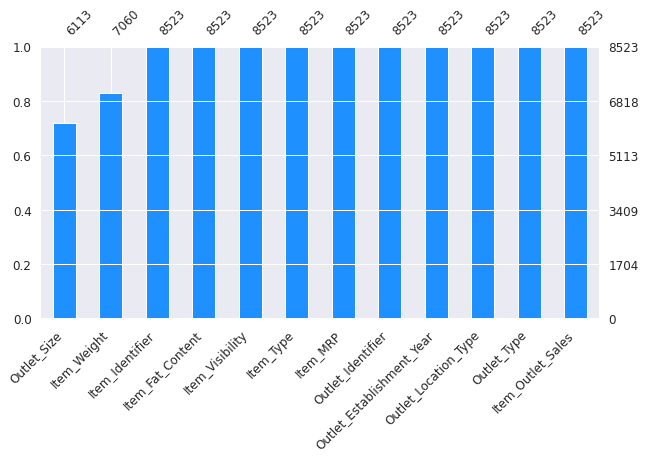

In [217]:
# Create a bar graph to get a visual of the frequency of NaN values in the various columns.
missingno.bar(sales_df, color="dodgerblue", figsize=(10,5), fontsize=12, sort="ascending")

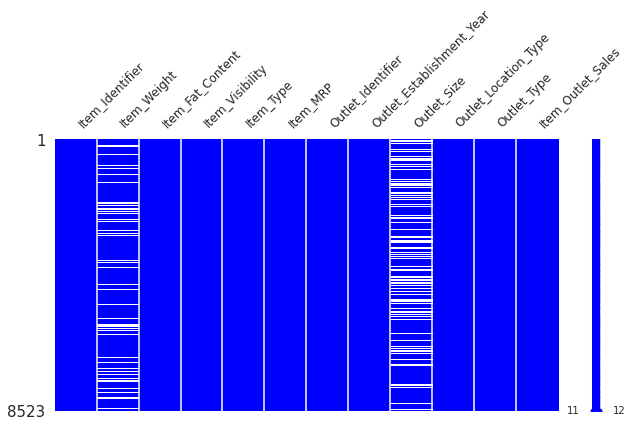

In [218]:
# Create a high level view of where the NaN values occur relative to eachother.
missingno.matrix(sales_df, color=(0,0,1), figsize=(10,5), fontsize=12)

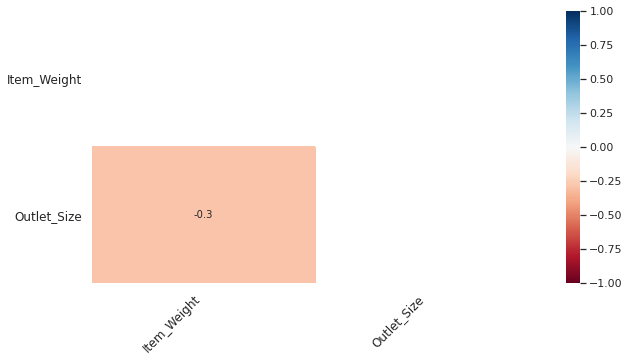

In [219]:
# Create a heat map showing how the missing values in Outlet_Size column correlate to missing values in Item_weight column.
missingno.heatmap(sales_df, figsize=(10,5), fontsize=12)

### Imputing the missing values

In [220]:
# Impute missing values in the 'Outlet_Size' column with the value 'missing'. This essentially adds a new class to the 'Outlet_Size' feature that the ML model can then learn. 
categorical_imputer = SimpleImputer(strategy='constant', fill_value='missing', add_indicator = True)
sales_df['Outlet_Size'] = categorical_imputer.fit_transform(sales_df[['Outlet_Size']])


In [221]:
# Impute missing values in the 'Item_Weight' column using the mean of the other weights. 
numerical_imputer = SimpleImputer(add_indicator=True)
sales_df['Item_Weight'] = numerical_imputer.fit_transform(sales_df[['Item_Weight']])

In [222]:
# Verify that after imputing, the data frame no longer has any missing values. 
sales_df.isnull().sum().sum()

0

# Summary Statistics

In [223]:
# Summary statistics for the numerical data.
sales_df.describe()

Item_Weight  ...  Item_Outlet_Sales
count  8523.000000  ...        8523.000000
mean     12.857645  ...        2181.288914
std       4.226124  ...        1706.499616
min       4.555000  ...          33.290000
25%       9.310000  ...         834.247400
50%      12.857645  ...        1794.331000
75%      16.000000  ...        3101.296400
max      21.350000  ...       13086.964800

[8 rows x 5 columns]

In [224]:
# Summary statistics for the categorical data.
sales_df.describe(include=[object])

Item_Identifier Item_Fat_Content  ... Outlet_Location_Type        Outlet_Type
count             8523             8523  ...                 8523               8523
unique            1559                2  ...                    3                  4
top              FDW13          Low Fat  ...               Tier 3  Supermarket Type1
freq                10             5517  ...                 3350               5577

[4 rows x 7 columns]

In [225]:
# List of unique years that these outlets were established.
sales_df['Outlet_Establishment_Year'].sort_values().unique()

array([1985, 1987, 1997, 1998, 1999, 2002, 2004, 2007, 2009])

In [226]:
#------------------------------------------------------------------------------------------------
# Displaying a breakdown of Item_Outlet_Sales by Item_Type. 
# Summary statistics Max, Min, Mean and Median are calculated for each item time.
# This summary is sorted by the 'Max' Item_Outlet_Sales for each item type.
#------------------------------------------------------------------------------------------------

grouped_sales = sales_df.groupby(by="Item_Type")[['Item_Outlet_Sales']].agg([max, min, np.mean, np.median])
grouped_sales.sort_values(by=[('Item_Outlet_Sales',    'max')], ascending=False)

Item_Outlet_Sales                                  
                                    max       min         mean     median
Item_Type                                                                
Household                    13086.9648   33.2900  2258.784300  1981.4208
Fruits and Vegetables        12117.5600   45.2744  2289.009592  1830.9500
Snack Foods                  10993.6896   33.9558  2277.321739  1944.1360
Canned                       10306.5840   37.9506  2225.194904  1860.2452
Dairy                        10256.6490   40.6138  2232.542597  1650.8511
Health and Hygiene            9779.9362   34.6216  2010.000265  1669.4935
Frozen Foods                  9678.0688   36.6190  2132.867744  1687.1372
Soft Drinks                   9554.2300   33.2900  2006.511735  1518.0240
Meat                          9390.4432   47.9376  2158.977911  1829.6184
Breads                        8958.3390   35.2874  2204.132226  1860.2452
Breakfast                     8209.3140   39.9480  2111.808651  1554.6430
Starchy Foods                 8132.0812   58.5904  2374.332773  1968.1048
Baking Goods                  7931.6754   37.2848  1952.971207  1577.9460
Hard Drinks                   7843.1240   37.9506  2139.221622  1816.6353
Seafood                       6503.5344  149.8050  2326.065928  2055.3246
Others                        6008.8450   39.9480  1926.139702  1713.7692

# Exploratory Data Analysis - Visualizations

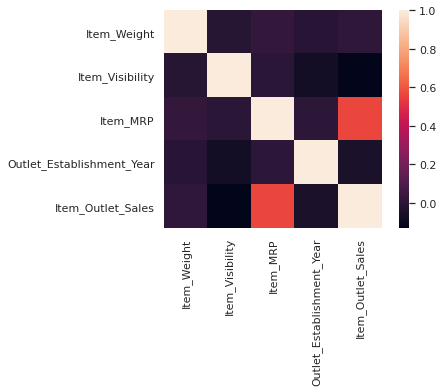

In [227]:
#--------------------------------------------------------------------------------------------------------------
# Creating a heatmap to visual the correlations between all numerical numerical predictors and the response.
#
# Observations
# 1) The most correlated (numerical) feature with Item_Outlet_Sales is item price (Item_MRP).
#--------------------------------------------------------------------------------------------------------------

correlation_matrix = sales_df.corr()
fig, ax = plt.subplots()
sns.heatmap(correlation_matrix, square=True);

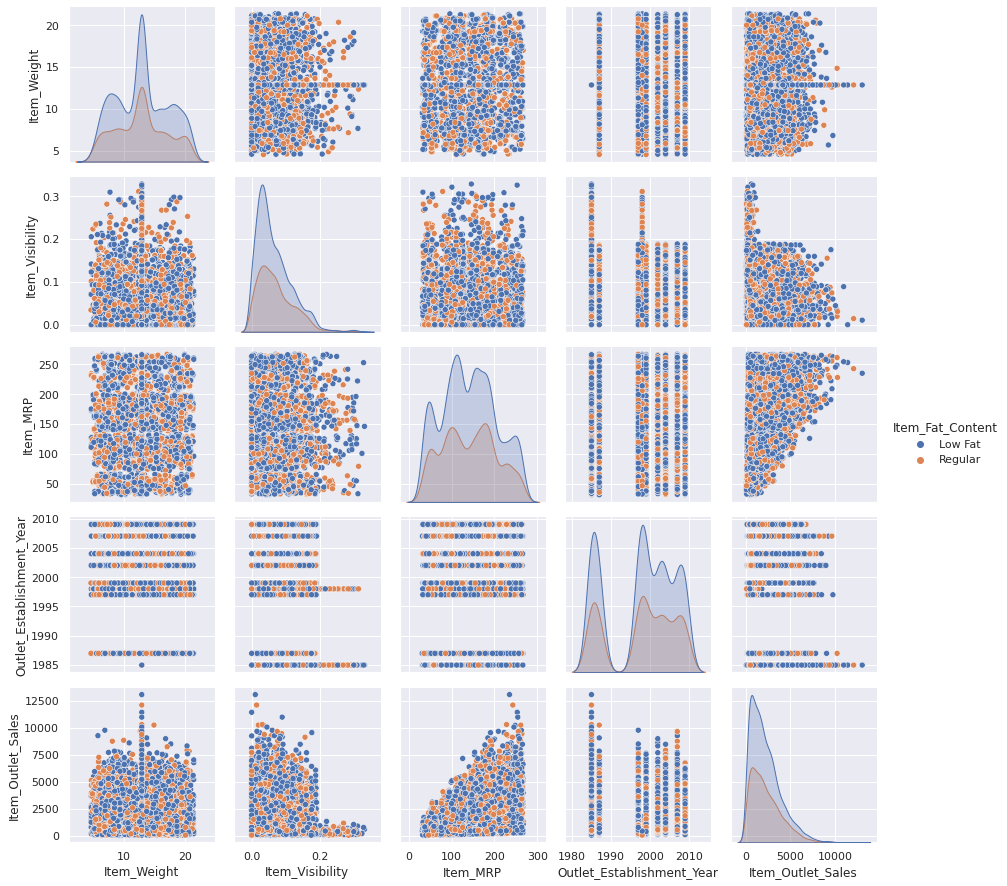

In [228]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a pairplot of all numerical columns in the sales_df dataframe. 
# Coloring of each data point depends on the value of the categorical feature Item_Fat_Content.
#
# Observations
# 1) Item_Outlet_Sales vs Item_Visibility is right (positively) skewed. (Observe the plot on the bottom row, second column, and note that there is a long 
#    tail on the right hand side of the plot).  
# 2) There seems to be two distinct clusters in Outlet_Establishment_Year. One in the late 1980's and another spanning late 1990's-2000's.
# 3) There is a positive trend where increasing Item_MRP is associated with increasing Item_Outlet_Sales. (confirms what we saw in the correlation heatmap).
# 4) Overall it seems like Low fat and Regular fat products are about evenly represented. There may be some indication that older establishments
#    tend to sell more low fat products. 
# 5) A column of datapoints exists at Item_Visibility = 0. Worth noting because it is unlikely any times truly have zero visibility. 
#---------------------------------------------------------------------------------------------------------------------------------------------------------------

sns.pairplot(sales_df, hue='Item_Fat_Content');

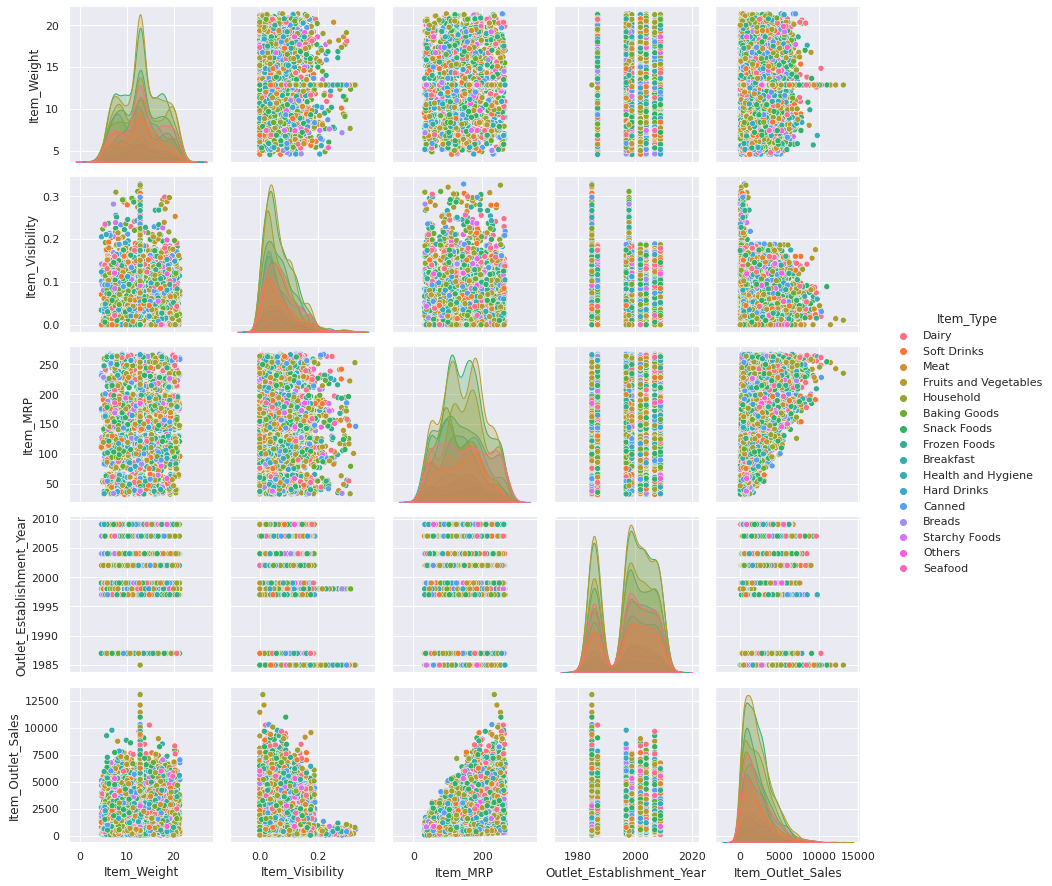

In [229]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a pairplot of all numerical columns in the sales_df dataframe. 
# Coloring of each data point depends on the value of the categorical feature Item_Type.
#
# Observations
# There may be too many color categories here to draw specific conclusions. In general this plot seems to be heavily represented by the 
# different shades of green, indicating that, for example, "Household" is common.
#---------------------------------------------------------------------------------------------------------------------------------------------------------------

sns.pairplot(sales_df, hue='Item_Type');

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


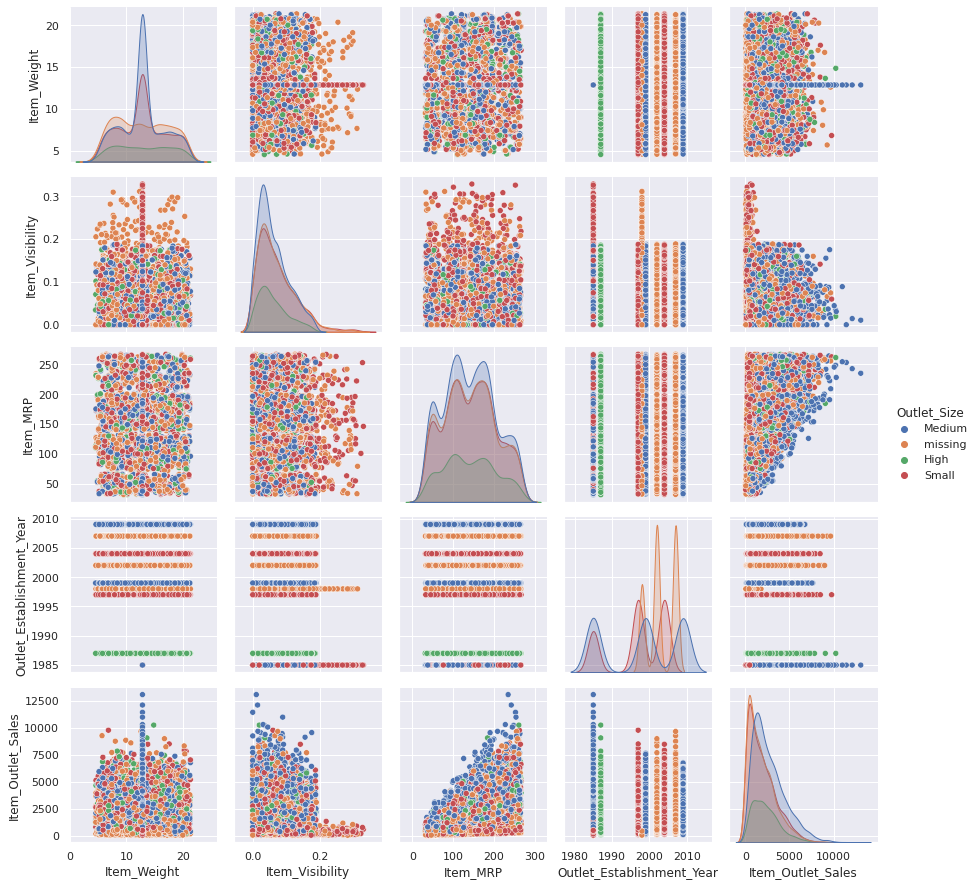

In [230]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a pairplot of all numerical columns in the sales_df dataframe. 
# Coloring of each data point depends on the value of the categorical feature Outlet_Size.

# Observations
# 1) There is a clear ordering amonst Outlet_Establishment_Year and Outlet_Size (colors in this chart --> bottom row, forth plot). 
# 2) Medium sized outlets are more frequent near the top of the Item_Outlet_Sales vs Item_MRP chart, indcating medium sized outlets are 
#    more likely to have a higher Item_Outlet_Sales for a given Item_MRP. 
#---------------------------------------------------------------------------------------------------------------------------------------------------------------

sns.pairplot(sales_df, hue='Outlet_Size');

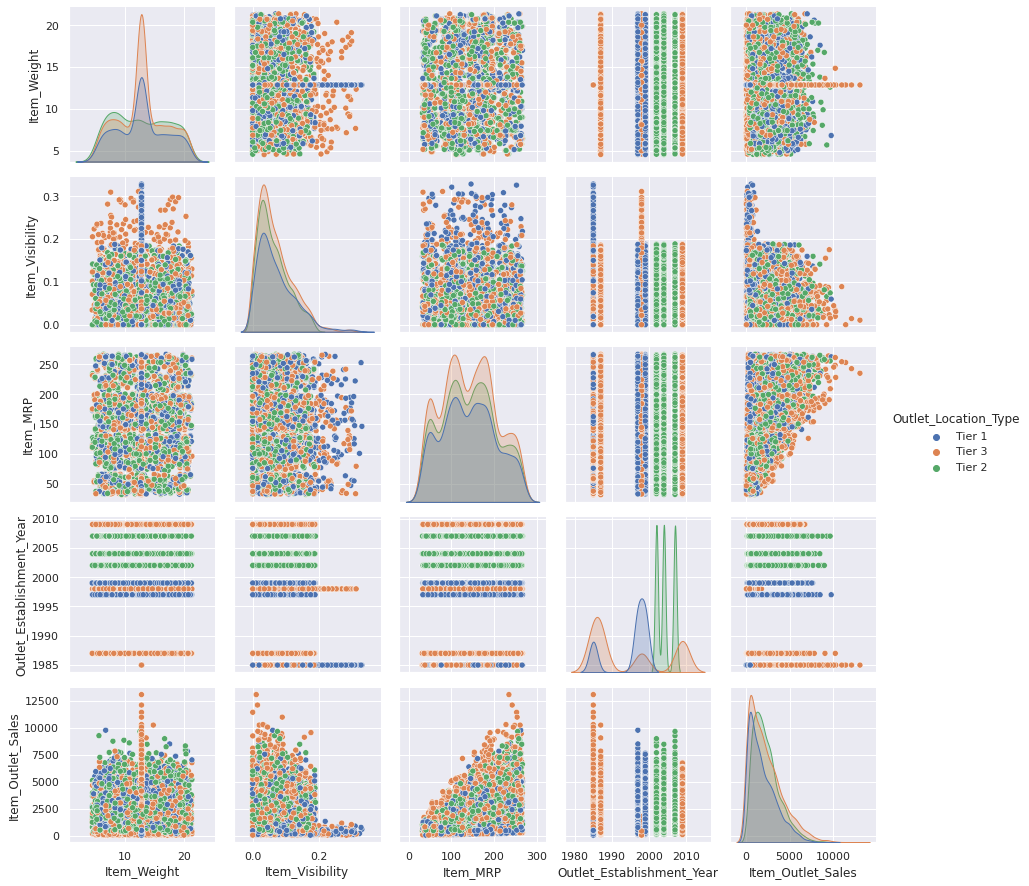

In [231]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a pairplot of all numerical columns in the sales_df dataframe. 
# Coloring of each data point depends on the value of the categorical feature Outlet_Location_Type.

# Observations
# 1) Similar to above, there is an association with 'Outlet_Establishment_Year' and the 'Outlet_Location_Type'.
#    Specifically, late 1980's comapnies are heavily tier 3, then there was a shift to Tier 1 in the late 1990s, 
#    then Tier 2 in the early to mid 2000's. Tier 3 appears again in the late 2000's. 
#
# 2) We may refer to the categorical feature of Outlet_Location_Type as "Ordinal" due to the clear ordering 
#    we can observe amongst its possible values. (Same would go for Outlet_Size above).
#---------------------------------------------------------------------------------------------------------------------------------------------------------------

sns.pairplot(sales_df, hue='Outlet_Location_Type');

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


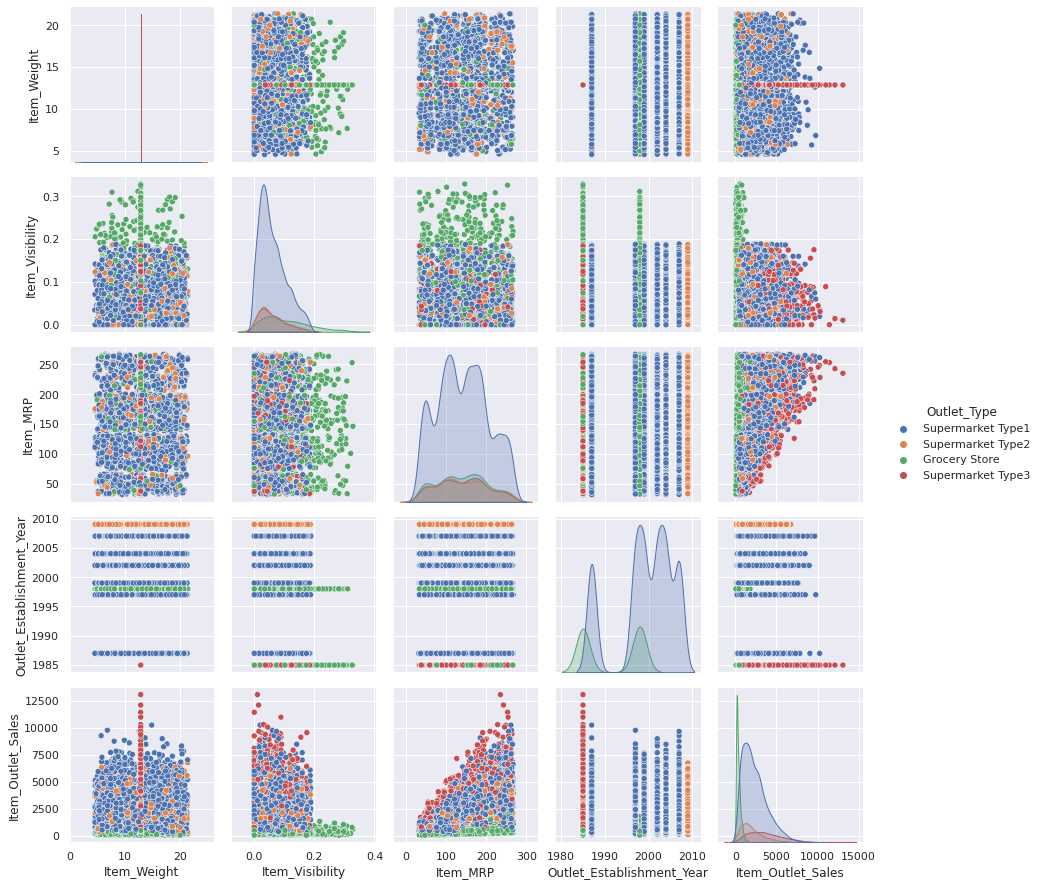

In [232]:
#---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a pairplot of all numerical columns in the sales_df dataframe. 
# Coloring of each data point depends on the value of the categorical feature Outlet_Type.
#
# Observations
# 1) There is an association between Outlet_Establishment_Year and the Outlet_Type. (Ordering amonst the values, similar to what was mentioned 
#    with Outlet_Location_Type and Outlet_Size).
#
# 2) For a given Item_MRP, Supermarket Type3 stores seem to have the highest Item_Outlet_Sales, while Grocery Stores have the lowest. Type 1 
#    and Type 2 Supermarkets are somewhere in betweeen. 
#
# 3) Similar to above, for a given Item_Visibility, type3 Supermarkets have the highest Item_Outlet_Sales while Grocery Stores have the lowest. 
#
# 4) The mean Item_Weight value is extremely pronounced because there were several missing values in this column, and we chose to impute them all using the mean.
#    (This is true of all the above pairplots as well). This plot shows that many of these missing values were for Supermarket Type3 stores. 
#    The fact that the mean is now so pronounced compared to any other value, because of a data cleaning decision we made, is a reason to pause
#    and consider whether or not the decision to impute using the mean is the best decision for this data set. 
#---------------------------------------------------------------------------------------------------------------------------------------------------------------
sns.pairplot(sales_df, hue='Outlet_Type');

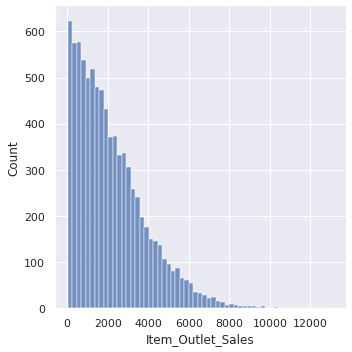

In [233]:
# ---------------------------------------------------------------------------------------------------
# Univariate Exploratory Data Analysis. 
# Visualize continuous variables using histograms, and categorical variables using bar (count) plots.
# ---------------------------------------------------------------------------------------------------

# Observations
# This histogram shows that our target variable is "right" or "positively" skewed. We can fix this skew by applying a transformation such as
# a cubed root or logarithmic transformation. 

sns.displot(sales_df, x="Item_Outlet_Sales")

# ---------------------------------------------------------------------------------------------------------------
# There are several reasons why skew in our predictor or response variables is undesireable. A couple are listed below: 
#
# 1) Conditions for inference with regression lines assumes that for a given set of predictors taken from the population, 
#    the associated distribution of the response variable is normal with constant variance. (Error terms are normally distributed). 
#    If our response variable is not normally distributed, it may be more likely that the error terms are also not normally distrbuted
#    (skewed residuals), which can then lead to issues with machine learning models that assume the error terms have constant variance. 
# 
# 2. If we train a model using a response variable that is skewed, the model may be less likely to successfully predict
#    outcomes associated with less frequent inputs (outcomes where less training data was used to train the model).  
#
# ---------------------------------------------------------------------------------------------------------------

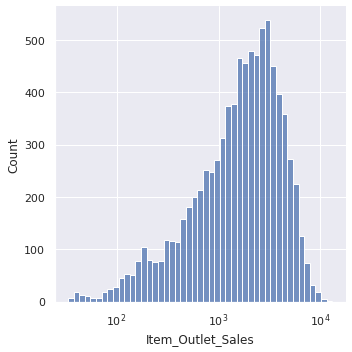

In [234]:
# Same plot as above, now viewed on a log scale.
sns.displot(sales_df, x="Item_Outlet_Sales", log_scale=True)

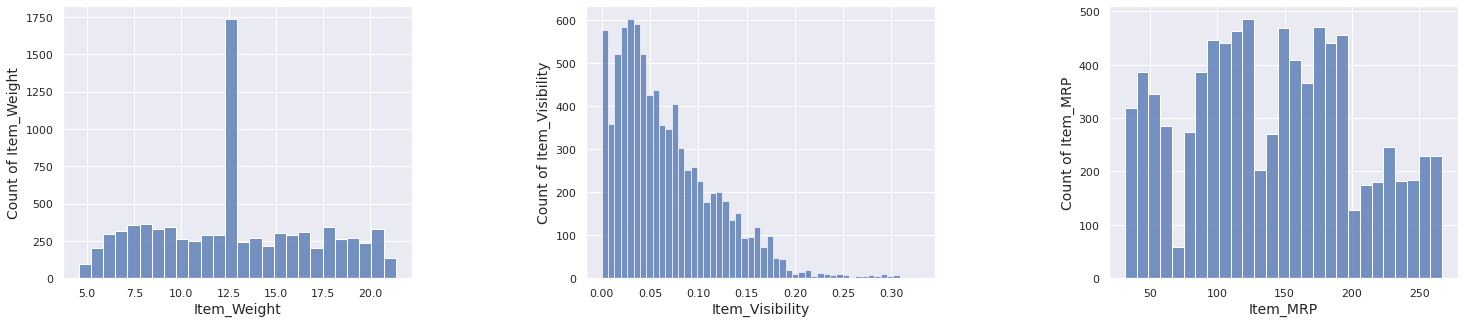

In [235]:
# ---------------------------------------------------------------------------------------------------------------
# Creating hisograms for the numerical features Item_Weight, Item_Visibility, and Item_MRP.
# ---------------------------------------------------------------------------------------------------------------

# wspace --> The amount of width reserved for space between subplots, expressed as a fraction of average axis width.
# hspace --> The amount of height reserved for space between suplots, expressed as fraction of average axis height.

fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(25.0,5.0), gridspec_kw = {'wspace':0.5, 'hspace':1.0})

sns.histplot(sales_df, x="Item_Weight", ax=axs[0][0])
sns.histplot(sales_df, x="Item_Visibility", ax=axs[0][1])
sns.histplot(sales_df, x="Item_MRP", ax=axs[0][2])

plot_labels = ["Item_Weight", "Item_Visibility", "Item_MRP"]

for index, label in enumerate(plot_labels): 
  axs[0][index].set_ylabel("Count of " + label, fontsize=14)
  axs[0][index].set_xlabel(label, fontsize=14)

# -------------------------------------------------------------------------------------------------------------------------------------------------------
# Observations
# 1) The plot on the left has a huge spike where we imputed values using the mean. This is certainly something to take note of, and is worth 
#    considering if imputation using the mean was the best option. 
# 2) Item visibility (middle plot) is skewed, we will likely need to transform this before using any machine learning models on it. 
# 3) Item_MRP looks somewhat multimodal (four humps). Not a super obvious pattern to the data but definitely not a normal distribution. 
# -------------------------------------------------------------------------------------------------------------------------------------------------------

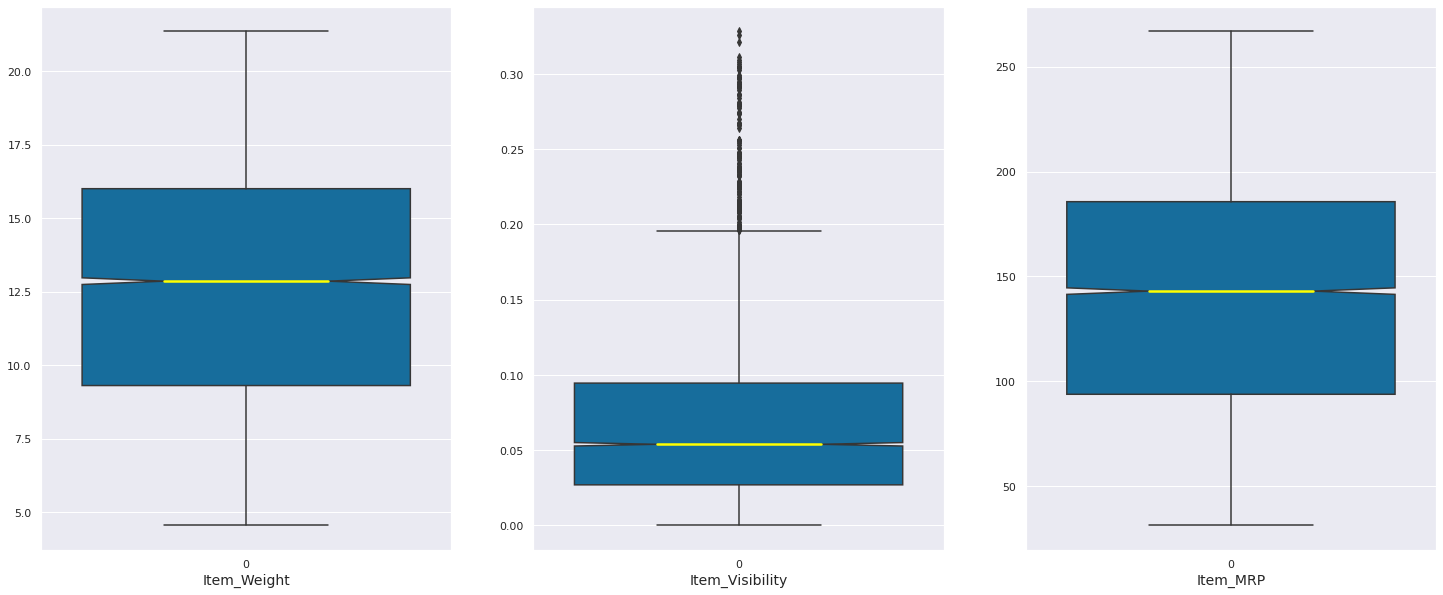

In [236]:
# ---------------------------------------------------------------------------------------------------------------
# Creating boxplots for the numerical features Item_Weight, Item_Visibility, and Item_MRP.
# ---------------------------------------------------------------------------------------------------------------

fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(25.0,10.0), gridspec_kw = {'wspace':0.2, 'hspace':0.5})

features = ["Item_Weight", "Item_Visibility", "Item_MRP"]

for index, feature in enumerate(features): 

  sns.boxplot(data=sales_df.loc[:, feature], palette="colorblind", ax=axs[0][index], notch=True,
            medianprops=dict(linestyle='-', linewidth=2.5, color='Yellow'))

  axs[0][index].set_xlabel(feature, fontsize=14)

  # ---------------------------------------------------------------------------------------------------------------
  # Observations
  # 1. There are a significant number of outliers in the Item_Visibility distribution. 
  # ---------------------------------------------------------------------------------------------------------------

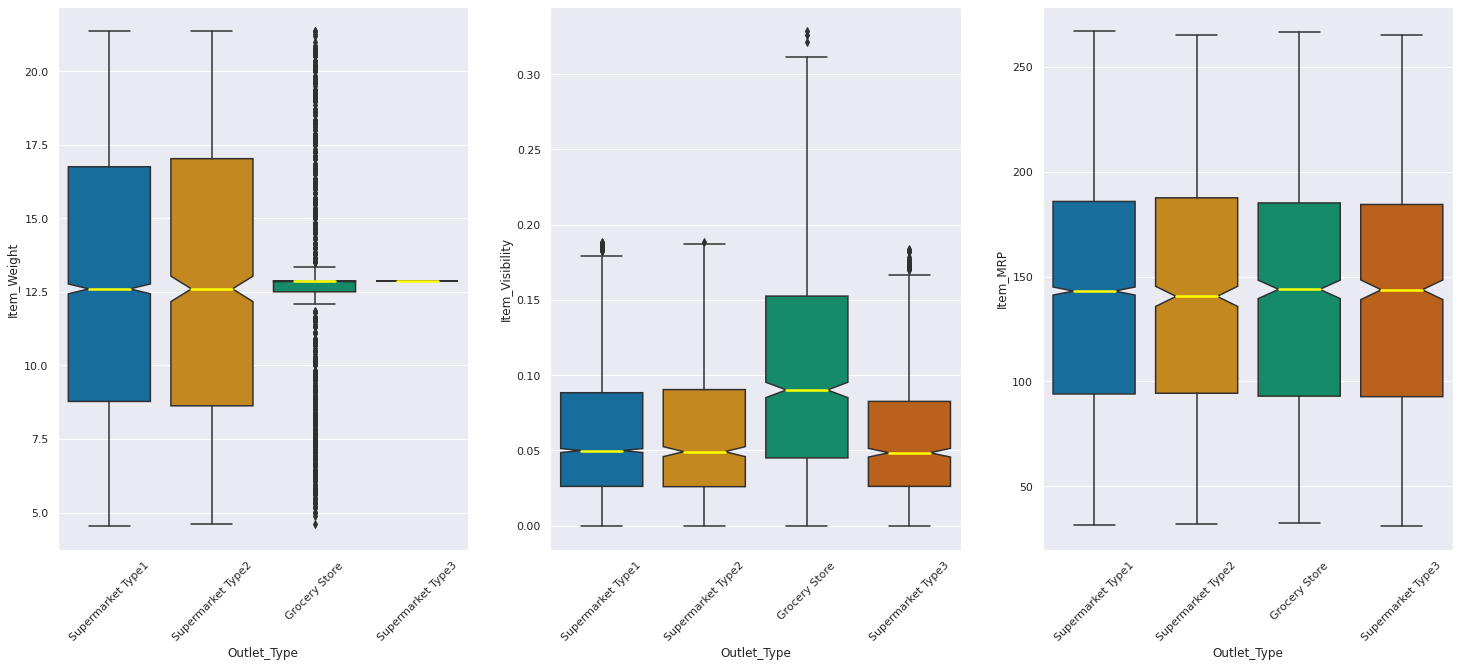

In [237]:
# ----------------------------------------------------------------------------------------------------------------------------------
# Creating boxplots to compare the numerical features Item_Weight, Item_Visibility, and Item_MRP accross each Outlet_Type
# ----------------------------------------------------------------------------------------------------------------------------------
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(25.0,10.0), gridspec_kw = {'wspace':0.2, 'hspace':0.5})

features = ["Item_Weight", "Item_Visibility", "Item_MRP"]

for index, feature in enumerate(features): 

  sns.boxplot(x='Outlet_Type', y=feature, data=sales_df, palette="colorblind", ax=axs[0][index], notch=True,
            medianprops=dict(linestyle='-', linewidth=2.5, color='Yellow'))
  tick_labels = axs[0][index].get_xticklabels()
  plt.setp(tick_labels, rotation=45)

In [238]:
Grocery_and_SMType3 = sales_df.loc[(sales_df['Outlet_Type'] == "Supermarket Type3") | (sales_df['Outlet_Type'] == "Grocery Store"), : ]
Grocery_and_SMType3.groupby(by='Outlet_Type')['Item_Weight'].value_counts()

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Observations
# 1. The set of box plots on the left side in the cell above (combined with the output of this cell) is a bit alarming. (but confirms what we saw in the pairplots).
#    100% of the Item_Weight values for Supermarket Type3 stores are equal to the mean value we imputed. 
#    Also, a significant portion of Item_Weight values for Grocery Stores (528 out of 8523) are equal to the mean value we imputed. 
#    These 528 occures of item weight = 12.857645 for Grocery Stores is much higher than the next frequent value (8 occurences).

#    The result is that for Supermarket Type 3 stores, the distribution of item weights is now uniform at 12.857 which is very unlikely to be accurate.
#    For Grocery Stores, the distribution is so heavily impacted by the 528 item weights equaling 12.857 that values that are likely "within family"
#    are now being flagged as outliers.
#
# 2.  Distribution of item visibility seems consistent across Supermarket Types, but is more spread out for Grocery Stores. The excess outliers we noted in
#     for item visibility in the previously plot is likely due to the wider Item_Visibility distribution for Grocery Stores comapred to Supermarkets. 
#
# 3.  Item MRP is consistent across Outlet_Types.
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

Outlet_Type        Item_Weight
Grocery Store      12.857645      528
                   9.300000         8
                   12.150000        8
                   15.200000        8
                   17.700000        8
                                 ... 
                   20.250000        1
                   21.000000        1
                   21.200000        1
                   21.250000        1
Supermarket Type3  12.857645      935
Name: Item_Weight, Length: 250, dtype: int64

In [239]:
sales_df.loc[sales_df['Outlet_Establishment_Year'] == 1985, "Outlet_Type"].value_counts()

Supermarket Type3    935
Grocery Store        528
Name: Outlet_Type, dtype: int64

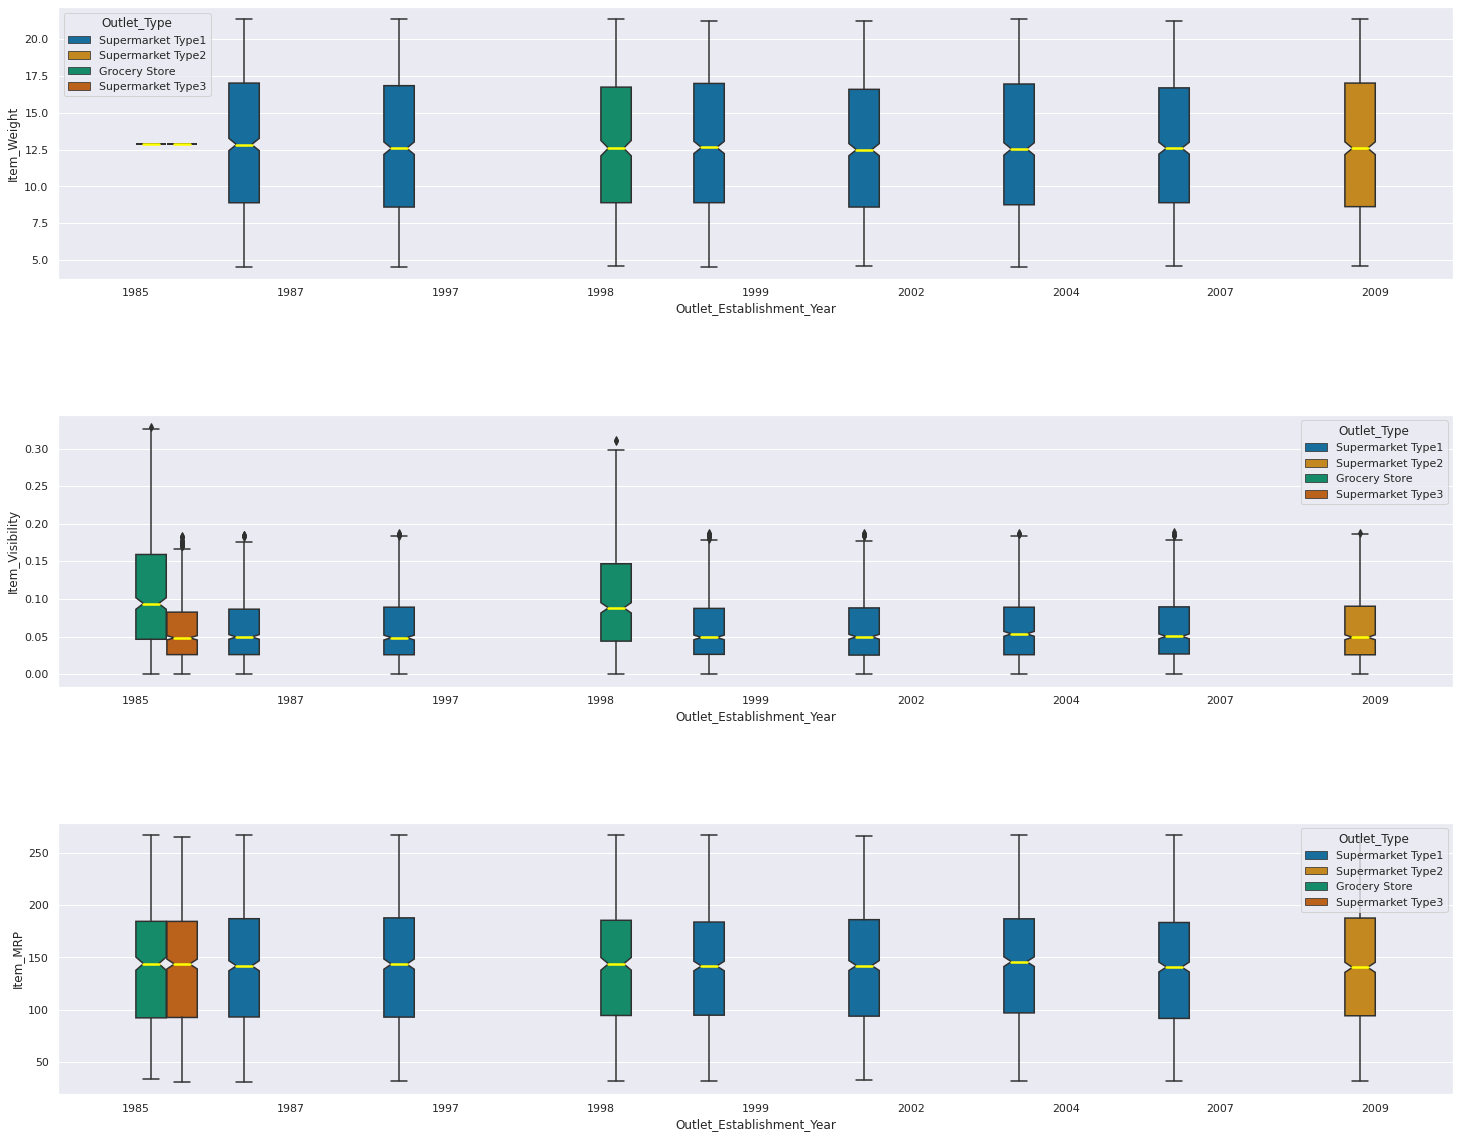

In [240]:
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Observations
# 1. There are two different Outlet_Types established in 1985 (Supermarket Type3 and Grocery Store). For both of these Outlet_Types, 100% of the Item_Weight values
#    are the mean we imputed. In fact (referencing the two cells above) we can state that for Grocery and Supermarket Type3 stores, 100% of the missing Item_Weight
#    values came from stores established in 1985. Why don't stores esablished in 1985 have item weight data? Are they missing some piece of equipement used to record this? 
#    Can we get this data some other way?  
#
#   *** Also note that the distribution of weights across all other years seems to be very consistent. Instead of using the mean, can we impute the missing weights for 
#       1985 stores such that the distribution of weights matches the distribution for other store type/years? 
# 
# 2. Distribution of item visibility values seems consistent (across years) once you control for outlet type.
#
# 3. Somewhat suprisingly, Distribution of Item MRP seems fairly consistent regardless or outlet_type or year. Inflation from 1985 to 2009 didn't change (or even shift) the distribution of Item MRP? 
#    The different outlet types don't offer different distributions of prices? 
#
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------------

fig, axs = plt.subplots(nrows=3, ncols=1, squeeze=False, figsize=(25.0,20), gridspec_kw = {'wspace':0.2, 'hspace':0.5})

features = ["Item_Weight", "Item_Visibility", "Item_MRP"]

for index, feature in enumerate(features): 

  sns.boxplot(x='Outlet_Establishment_Year', y=feature, data=sales_df, hue="Outlet_Type", palette="colorblind", ax=axs[index][0], notch=True,
            medianprops=dict(linestyle='-', linewidth=2.5, color='Yellow'))

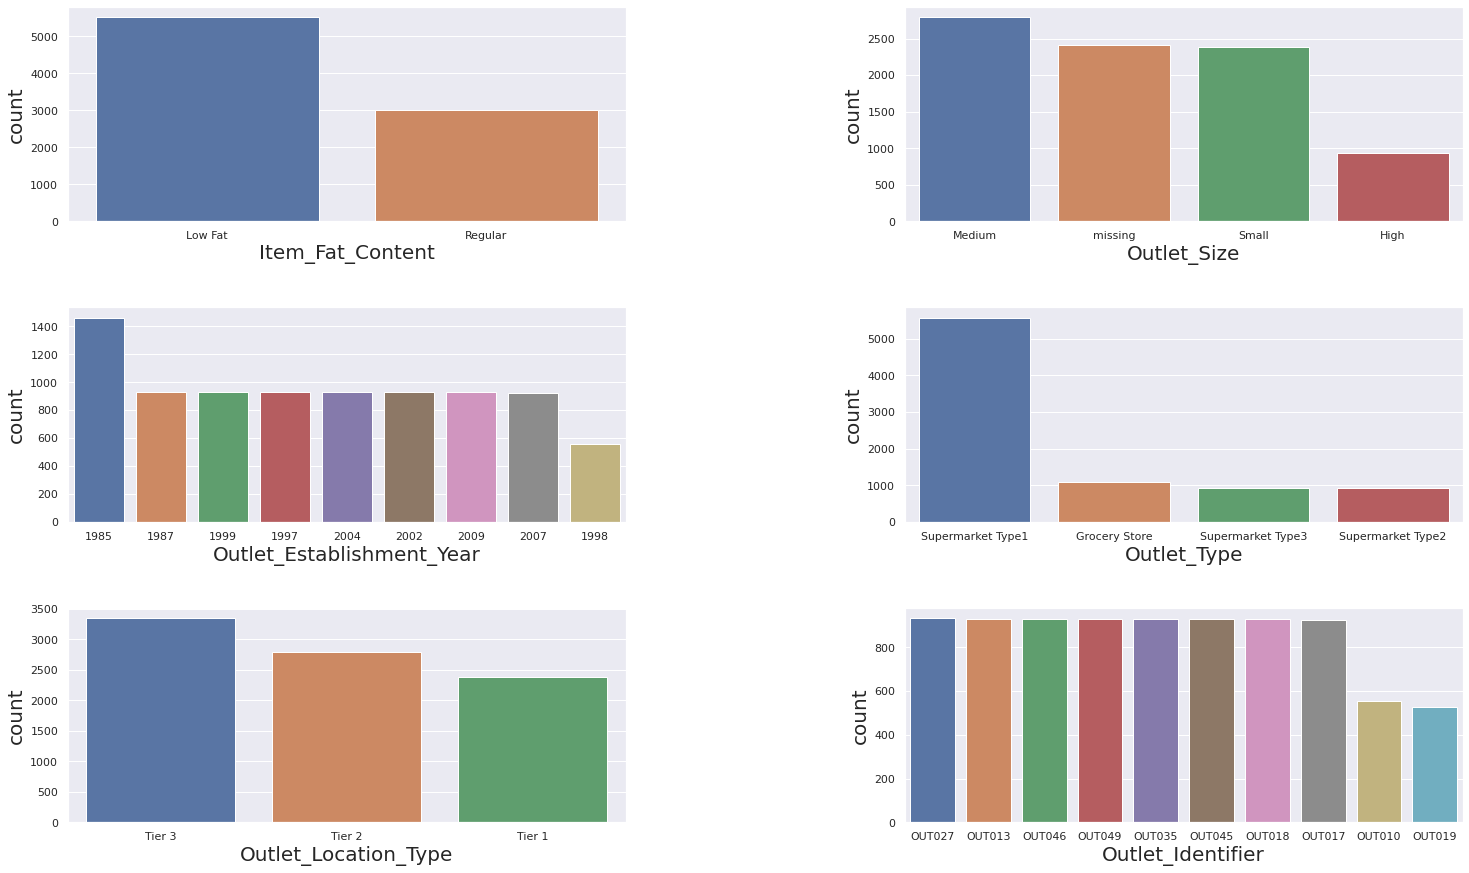

In [241]:
# ---------------------------------------------------------------------------------------------------------------
# Creating count plots for categorical features.
# ---------------------------------------------------------------------------------------------------------------

fig, axs = plt.subplots(nrows=3, ncols=2, squeeze=False, figsize=(25.0,15.0), gridspec_kw = {'wspace':0.5, 'hspace':0.4})

features = ['Item_Fat_Content', 'Outlet_Size', 'Outlet_Establishment_Year', 'Outlet_Type', 'Outlet_Location_Type', 'Outlet_Identifier']

for index, feature in enumerate(features): 
  row = index // 2 
  col = index % 2
  sns.countplot(x=feature, data=sales_df, order=sales_df[feature].value_counts().index, ax=axs[row][col])
  axs[row][col].set_xlabel(feature, fontsize=20)
  axs[row][col].set_ylabel('count', fontsize=20)

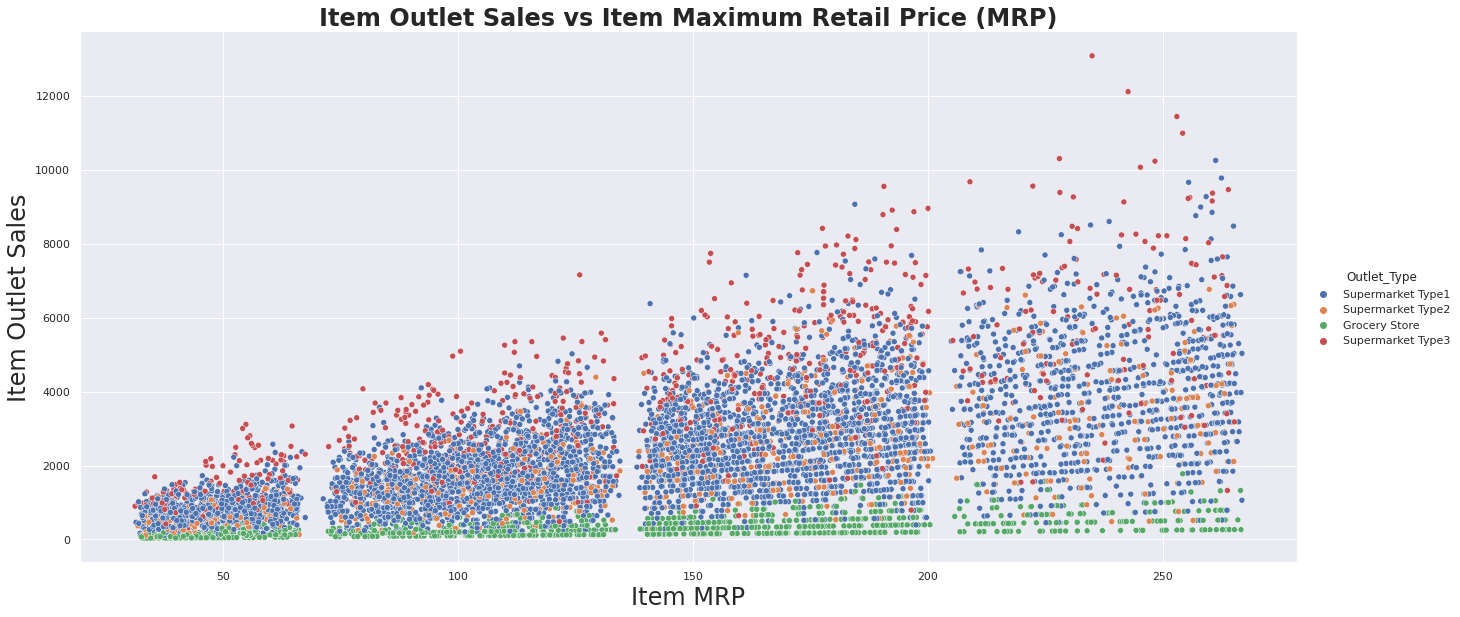

In [242]:
# -------------------------------------------------------------------------------------------------------------------------------------------
# Below is a full size chart of Item Outlet Sales vs Item Maximum Retail Price. This chart was included in the pairplots above, however
# with the pairplots small chart size a characteristic of the chart was difficult to see. As shown below, the Item_MRP feature is 
# naturally broken up into four distinct price segments. These segments could be used in feature engineering to create a new variable. 
# -------------------------------------------------------------------------------------------------------------------------------------------

sns.set_theme(style="darkgrid")

g = sns.relplot(x="Item_MRP", y='Item_Outlet_Sales', data=sales_df, hue='Outlet_Type', height=8, aspect=2.25)

g.ax.set_title("Item Outlet Sales vs Item Maximum Retail Price (MRP)", fontsize="24", fontweight="bold")
g.set_xlabels("Item MRP", fontsize=24)
g.set_ylabels("Item Outlet Sales", fontsize=24)